In [35]:
import numpy as np
from numpy import linalg as LA
import matplotlib.pyplot as plt
import copy
from multiprocessing import Pool, Manager
import functools

In [36]:
N = 108
Lx = Ly = Lz = 18
sigma = 3.4
eps = .238

L = np.array([Lx, Ly, Lz])

## Some common functions used throughout the code

In [37]:
def get_distance(A, B):
    d = B - A
    r = d - (np.round(d / L) * L)
    return np.sqrt(np.sum(r ** 2))

In [38]:
def get_random(x):
    return np.random.uniform(0, x)

In [39]:
def read_file(filepath):
    points = np.zeros((N, 3))
    with open(filepath) as f:
        data = f.read().split('\n')
        for idx, line in enumerate(data[2:]):
            a = line.split()
            points[idx] = np.array([float(x) for x in a[1:]])
    return points

## Creating the initial Configuration
The following is the code for getting the configuartion. The following could take a lot of time in running. Hence, a random configuration is already made in `configuration.txt` file provided which is used in further sections. On running the code, the new configuration will be made in `configurationEval.txt`

In [11]:
def write_config_file(filepath, points):
    with open(filepath, 'w') as fd:
        print(points.shape[0], file=fd)
        print("#comment initial random config", file=fd)
        for c in points:
            print(f"C {c[0]} {c[1]} {c[2]}", file=fd)

In [12]:
def get_configuration():
    configuration = []
    while len(configuration) < N:
        A = np.array([get_random(x) for x in L])
        got = True
        for B in configuration:
            if get_distance(A, B) < sigma:
                got = 0
                break
        if got:
            configuration.append(A)
    return np.array(configuration)

In [ ]:
configuration = get_configuration()
write_config_file("./configurationEval.txt", configuration)

## Total Interaction Energy
The following code snippet calculates the total interaction energy of the configuration

In [40]:
def get_pair_interaction_energy(A, B):
    r = get_distance(A, B)
    z = sigma / r
    E = 4 * eps * ((z ** 12) - (z ** 6))
    return E

In [41]:
def get_total_interaction(points):
    interaction = sum(
        [get_pair_interaction_energy(x, points[j]) for i, x in enumerate(points)
         for j in range(i + 1, len(points))])
    return interaction

In [42]:
points = read_file('./configuration.txt')

interaction = get_total_interaction(points)
print('The total interaction energy for the following configuration is equal to', interaction,
      'kcal/mol')


The total interaction energy for the following configuration is equal to -122.63092381976412 kcal/mol


## Minimizing the total Potential Energy
The configuration for minimum possible energy is written in `new_configuration.txt`. The subsequent pieces of code use this configuration, hence on running the following the pieces of code, the new set of points are stored in `new_configurationEval.txt` to prevent data loss.

In [43]:
def get_pair_force(A, B):
    d = B - A
    rab = d - (np.round(d / L) * L)
    r = np.sqrt(np.sum(rab ** 2))
    z = sigma / r
    F = -0.01 * 4 * eps * ((-12 * (z ** 12)) + (6 * (z ** 6))) / r
    fv = abs(F) * rab / r
    return fv

In [44]:
def make_plot(title, xlab, ylab, plot):
    plt.title(title)
    plt.plot(plot)
    plt.xlabel(xlab)
    plt.ylabel(ylab)
    plt.show()

In [45]:
def get_minimum_potential(points):
    force_plot = []
    energy_plot = [get_total_interaction(points)]

    iterations = 200
    for k in range(iterations):
        net_force = 0
        force = np.zeros(points.shape)
        for i in range(len(points)):
            for j in range(i + 1, len(points)):
                f = get_pair_force(points[j], points[i])
                force[i] += f
                force[j] -= f
            points[i] += force[i]
            net_force += np.sqrt(np.sum(force[i] ** 2))

        force_plot.append(net_force)
        energy_plot.append(get_total_interaction(points))

        if net_force <= 0.01: break

    make_plot('Force plot', 'Iterations', 'Force', force_plot)
    make_plot('Energy plot', 'Iterations', 'Energy', energy_plot)

    return points

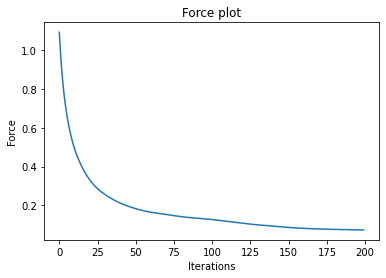

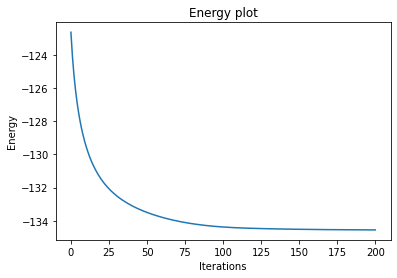

In [34]:
new_config_points = get_minimum_potential(copy.deepcopy(points))
write_config_file('./new_configurationEval.txt', new_config_points)

## Calculation of interaction energies
This calculation is done for knowing the values in Hessian matrix. The hessian matrix contains values as the second order derivatives of interaction energy. Therefore to approximate the derivative , we need to knw interaction energy of particles when they are displaced by small distance. The calculation time for this quite high, hence all the energy values are already stored in the file named as `hessianEnergy.txt`. Also we use multi-threading to speed up the process. To prevent data loss, on running the piece of code below, the data will be stored in `hessianEnergyEval.txt` 

In [54]:
energies = {}
h = 0.005  # The small displacement as stated above
particles = read_file('./new_configuration.txt')

In [55]:
def add_energy(dic, key, points):
    interaction = get_total_interaction(points)
    dic[key] = interaction

In [56]:
def processThreads(i, threadPool):
    dispParticles = copy.deepcopy(particles)
    print(i)
    x, qx = i % 3, i // 3
    for j in range(i):
        y, qy = j % 3, j // 3
        dispParticles[qx][x] += h
        dispParticles[qy][y] += h
        add_energy(threadPool, (i, j, 1, 1), dispParticles)
        dispParticles[qx][x] -= 2 * h
        dispParticles[qy][y] -= 2 * h
        add_energy(threadPool, (i, j, -1, -1), dispParticles)
        dispParticles[qx][x] += h
        dispParticles[qy][y] += h

In [57]:
def enableMultiThreading():
    pool = Pool()
    threadPool = Manager().dict()
    pool.map(functools.partial(processThreads, pool_dict=threadPool), [i for i in range(3 * N)])
    pool.close()
    pool.join()
    energies.update(threadPool)

In [58]:
def displace_particles():
    add_energy(energies, (0, 0, 0, 0), particles)
    dispParticles = copy.deepcopy(particles)
    for i in range(3 * N):
        x, qx = i % 3, i // 3
        dispParticles[qx][x] += h
        add_energy(energies, (i, 0, 1, 0), dispParticles)
        dispParticles[qx][x] -= 2 * h
        add_energy(energies, (i, 0, -1, 0), dispParticles)
        dispParticles[qx][x] += h
    enableMultiThreading()

In [ ]:
displace_particles()

with open('hessianEnergyEval.txt', 'w') as fd:
    for k, v in energies.items():
        print(f"{k} {v}", file=fd)

## Hessian Matrix Calculation
The calculation is continued with `hessianEnergy.txt`. The matrix is stored in file `hessianMatrix.txt`

In [87]:
energyHessian = {}


def read_energies():
    with open('hessianEnergy.txt') as f:
        data = f.read().split('\n')
        for line in data[:-1]:
            line = line.split(')')
            key, value = line[0][1:], line[1][1:]
            energyHessian[tuple(map(int, key.split(', ')))] = float(value)

In [88]:
def get_hessian():
    H = np.zeros((3 * N, 3 * N))
    for i in range(H.shape[0]):
        for j in range(i + 1):
            dh2 = (h ** (-2))
            if i == j:
                H[i][i] = dh2 * (energyHessian[(i, 0, 1, 0)] + energyHessian[(i, 0, -1, 0)]
                                 - 2 * energyHessian[(0, 0, 0, 0)])
            else:
                H[i][j] = 0.5 * dh2 * (energyHessian[(i, j, 1, 1)] + energyHessian[(i, j, -1, -1)]
                                       - energyHessian[(i, 0, 1, 0)] - energyHessian[(j, 0, 1, 0)]
                                       - energyHessian[(i, 0, -1, 0)] - energyHessian[(j, 0, -1, 0)]
                                       + 2 * energyHessian[(0, 0, 0, 0)])
                H[j][i] = H[i][j]
    return H

In [89]:
read_energies()
H = get_hessian()

with open('hessianMatrix.txt', 'w') as fd:
    print('\n'.join([' '.join([str(x) for x in row]) for row in H]), file=fd)

## Eigen values and vectors of Hessian Matrix
The corresponding eigen values and eigen vectors for the hessian matrix are stored in `eigenValues.txt` and `eigenVectors.txt`.

In [90]:
def get_eigen():
    return LA.eig(H)

In [91]:
values, vectors = get_eigen()

with open('eigenValues.txt', 'w') as fd:
    print('\n'.join([str(x) for x in values]), file=fd)

with open('eigenVectors.txt', 'w')as fd:
    print('\n'.join([str(x) for x in vectors]), file=fd)

## Vibrational Frequencies Histogram
The vibrational frequency histogram is basically making a histogram of eigen values obtained from the Hessian matrix.

In [92]:
def make_histogram():
    minimum_v = min(values) - 1
    maximum_v = max(values) + 2

    bins = np.arange(minimum_v, maximum_v, 1)
    fig, ax = plt.subplots(1, 1, figsize=(10, 7))
    ax.hist(values, bins=bins, ec='black')
    ax.set_xlabel('Values')
    ax.set_ylabel('Frequency of eigen values')
    plt.show()

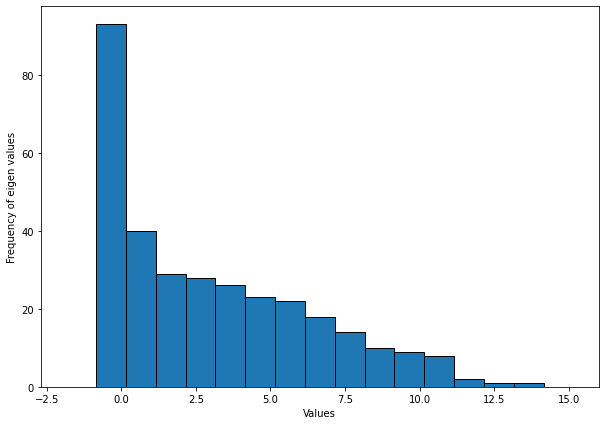

In [93]:
make_histogram()